<a href="https://colab.research.google.com/github/Darwin575/CSE422_Courseworks/blob/main/Finals_Lab_Exercise_2_Lariosa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Squash Image Classification using CNN with Data Augmentation and Regularization

__Project Goal: To build a CNN-based classifier
to accurately identify three types of squash (cucurbita_moschata, cucurbita_pepo, and sechium_edule) from images.__

### Data Loading and Preprocessing:
### Mounted Google Drive to access the image data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install tensorflow

### Imported necessary libraries (TensorFlow, Keras, ImageDataGenerator, etc.):

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [ ]:
import numpy as np

### Defined data paths and loaded images using ImageDataGenerator



In [ ]:
train_data_dir = '/content/drive/MyDrive/ANN/squashes'

In [ ]:
augmented_data_dir = '/content/drive/MyDrive/ANN/augmented_squashes' # Replace with desired directory for augmented images
os.makedirs(augmented_data_dir, exist_ok=True)


In [ ]:
import shutil
# Remove old augmented images and recreate directory
shutil.rmtree(augmented_data_dir, ignore_errors=True)
os.makedirs(augmented_data_dir, exist_ok=True)


### Data Augmentation

In [ ]:
# --- Data Augmentation ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# --- Function to Generate Augmented Images (with subfolder creation) ---
def generate_augmented_images(image_path, num_augmented_images=5):
    img = keras.preprocessing.image.load_img(image_path, target_size=(150, 150))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = img_array.reshape((1,) + img_array.shape)

    # Get the class label from the original image path
    class_label = os.path.basename(os.path.dirname(image_path))

    # Create a subfolder for the class in the augmented data directory
    class_augmented_dir = os.path.join(augmented_data_dir, class_label)
    os.makedirs(class_augmented_dir, exist_ok=True)

    i = 0
    for batch in train_datagen.flow(
        img_array,
        batch_size=1,
        save_to_dir=class_augmented_dir,  # Save to the class subfolder
        save_prefix='aug_',
        save_format='jpg'
    ):
        i += 1
        if i >= num_augmented_images:
            break

# --- Generate Augmented Images ---
for class_folder in os.listdir(train_data_dir):
    class_path = os.path.join(train_data_dir, class_folder)
    for image_file in os.listdir(class_path):
        image_path = os.path.join(class_path, image_file)
        generate_augmented_images(image_path, num_augmented_images=5)

# --- Data Generators ---
train_generator = train_datagen.flow_from_directory(
    augmented_data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    train_data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)


Found 1073 images belonging to 3 classes.
Found 213 images belonging to 3 classes.


In [ ]:
print("Train generator samples:", train_generator.samples)
print("Validation generator samples:", validation_generator.samples)

Train generator samples: 1073
Validation generator samples: 213


## Model Building

__Constructed a CNN model using Keras__

In [ ]:
from tensorflow.keras import regularizers

model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3), kernel_regularizer=regularizers.l2(0.00001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.001),   # Add dropout after the first MaxPooling layer
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.001),  # Add dropout after the second MaxPooling layer
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.001),  # Add dropout after the third MaxPooling layer
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    layers.Dropout(0.02),  # Keep or adjust dropout rate
    layers.Dense(3, activation='softmax')
])

### Model Training and Evaluation

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)


Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.7063 - loss: 0.7083 - val_accuracy: 0.7500 - val_loss: 0.6126
Epoch 2/10
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - accuracy: 0.7812 - loss: 0.6205

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 249ms/step - accuracy: 0.7812 - loss: 0.6205 - val_accuracy: 0.7708 - val_loss: 0.5965
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.7535 - loss: 0.6306 - val_accuracy: 0.8333 - val_loss: 0.5084
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 223ms/step - accuracy: 0.8438 - loss: 0.4917 - val_accuracy: 0.8021 - val_loss: 0.5412
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7573 - loss: 0.5933 - val_accuracy: 0.8125 - val_loss: 0.5152
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 263ms/step - accuracy: 0.7500 - loss: 0.5622 - val_accuracy: 0.7969 - val_loss: 0.5268
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7807 - loss: 0.5474 - val_accuracy: 0.7552 - val_loss: 0.6034
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.7812 - loss: 0.5978 - val_accuracy: 0.7552 - val_loss: 0.6406
Epoch 9/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7634 - loss: 0.5581 - val_accuracy: 0.8177 - val_loss:

### Evaluated the model

In [ ]:
print("Training Accuracy:", history.history['accuracy'][-1])
print("Validation Accuracy:", history.history['val_accuracy'][-1])
print("Training Loss:", history.history['loss'][-1])
print("Validation Loss:", history.history['val_loss'][-1])


Training Accuracy: 0.75
Validation Accuracy: 0.8125
Training Loss: 0.4931087791919708
Validation Loss: 0.5088580846786499


## Plot training history

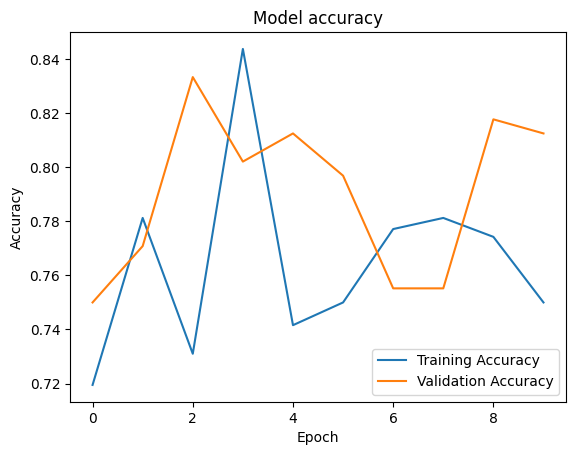

In [ ]:

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step


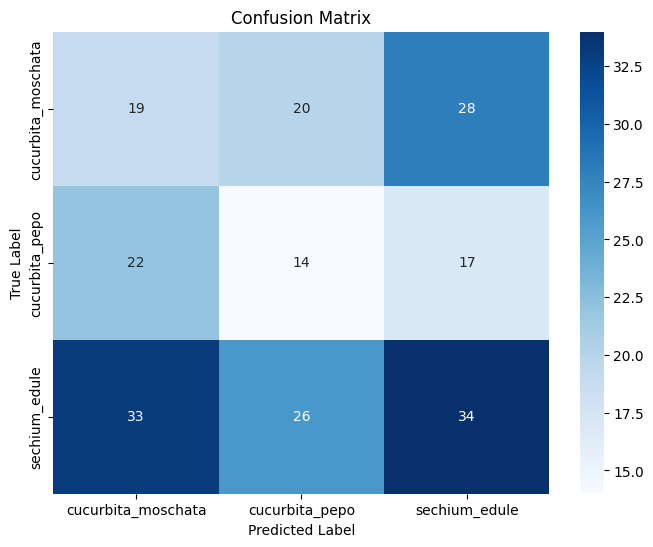

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns  # Import seaborn for better visualization

Y_pred = model.predict(validation_generator, validation_generator.samples // validation_generator.batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_generator.classes

cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=validation_generator.class_indices,
            yticklabels=validation_generator.class_indices)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

In [ ]:
# --- Evaluation ---
Y_pred = model.predict(validation_generator, validation_generator.samples // validation_generator.batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_generator.classes

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
cm = confusion_matrix(y_true, y_pred)
#auc = roc_auc_score(y_true, Y_pred, multi_class='ovr')  # For multi-class classification


print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"Confusion Matrix:\n{cm}")
#print(f"AUC: {auc}")  # For multi-class classification

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 662ms/step
Precision: 0.3381080759847029
Recall: 0.3286384976525822
F1-Score: 0.33175889385091367
Confusion Matrix:
[[22 14 31]
 [23 15 15]
 [29 31 33]]


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from google.colab import files
from io import BytesIO
from PIL import Image

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array  # Add this import

In [ ]:
def upload_and_predict(model):
    """Uploads an image, makes a prediction, and displays the results."""
    uploaded = files.upload()
    for fn in uploaded.keys():
        # Open the uploaded image
        img = Image.open(BytesIO(uploaded[fn]))

        # Make prediction
        predicted_class, confidence = predict_image_class(img, model)

        # Display the image and prediction
        display(img)
        print(f"Predicted Class: {predicted_class}")
        print(f"Confidence Score: {confidence:.2f}")

# --- Function to predict the class of an uploaded image ---
def predict_image_class(img, model):
    """Predicts the class of an image using the trained model.

    Args:
        img: PIL Image object.
        model: The trained Keras model.

    Returns:
        The predicted class label and the confidence score.
    """

    img = img.resize((150, 150))  # Resize the image
    img_array = img_to_array(img)  # Convert to NumPy array
    img_array = img_array / 255.0  # Rescale pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    prediction = model.predict(img_array)  # Make prediction
    predicted_class_index = np.argmax(prediction)  # Get predicted class index
    class_labels = list(train_generator.class_indices.keys())  # Get class labels
    predicted_class_label = class_labels[predicted_class_index]  # Get predicted class label
    confidence_score = prediction[0][predicted_class_index]  # Get confidence score

    return predicted_class_label, confidence_score

Saving images (4).jpg to images (4).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


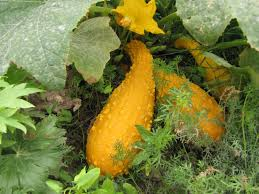

Predicted Class: cucurbita_pepo
Confidence Score: 0.95


In [ ]:
# --- Call the upload and predict function ---
upload_and_predict(model)